In [1]:
import numpy as np
import pandas as pd
from defillama2 import DefiLlama
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)
# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

### Download Data

Let's download umami and weth hourly price data from arbitrum using DefiLlama's 
data api. After that, we'll calculate UMAMIETH hourly prices by dividing the two 
price series, i.e., `UMAMI/WETH`.

In [2]:
dd = {'0x1622bF67e6e5747b81866fE0b85178a93C7F86e3':'arbitrum', # umami, arbitrum
      '0x82aF49447D8a07e3bd95BD0d56f35241523fBab1':'arbitrum', # weth, arbitrum
      }

# set download start and end dates
start_str = '2022-11-01'
end_str   = '2022-12-09'

In [3]:
llama = DefiLlama()
df = llama.get_tokens_hist_prices(dd, start_str, end_str, 'hourly')
print(df.head(), end='\n\n')
print(df.tail())

                     UMAMI     WETH
datetime                           
2022-11-01 00:00:00  28.51 1,573.18
2022-11-01 01:00:00  27.54 1,568.53
2022-11-01 02:00:00  25.39 1,579.61
2022-11-01 03:00:00  26.36 1,597.75
2022-11-01 04:00:00  25.58 1,589.79

                     UMAMI     WETH
datetime                           
2022-12-08 20:00:00  36.02 1,285.69
2022-12-08 21:00:00  34.28 1,276.71
2022-12-08 22:00:00  34.36 1,277.79
2022-12-08 23:00:00  34.57 1,282.76
2022-12-09 00:00:00  34.55 1,282.33


In [4]:
# calc BTCETH
df['UMAMIETH'] = df.UMAMI / df.WETH
df.tail()

,UMAMI,WETH,UMAMIETH
datetime,,,
2022-12-08 20:00:00,36.02,"1,285.69",0.03
2022-12-08 21:00:00,34.28,"1,276.71",0.03
2022-12-08 22:00:00,34.36,"1,277.79",0.03
2022-12-08 23:00:00,34.57,"1,282.76",0.03
2022-12-09 00:00:00,34.55,"1,282.33",0.03


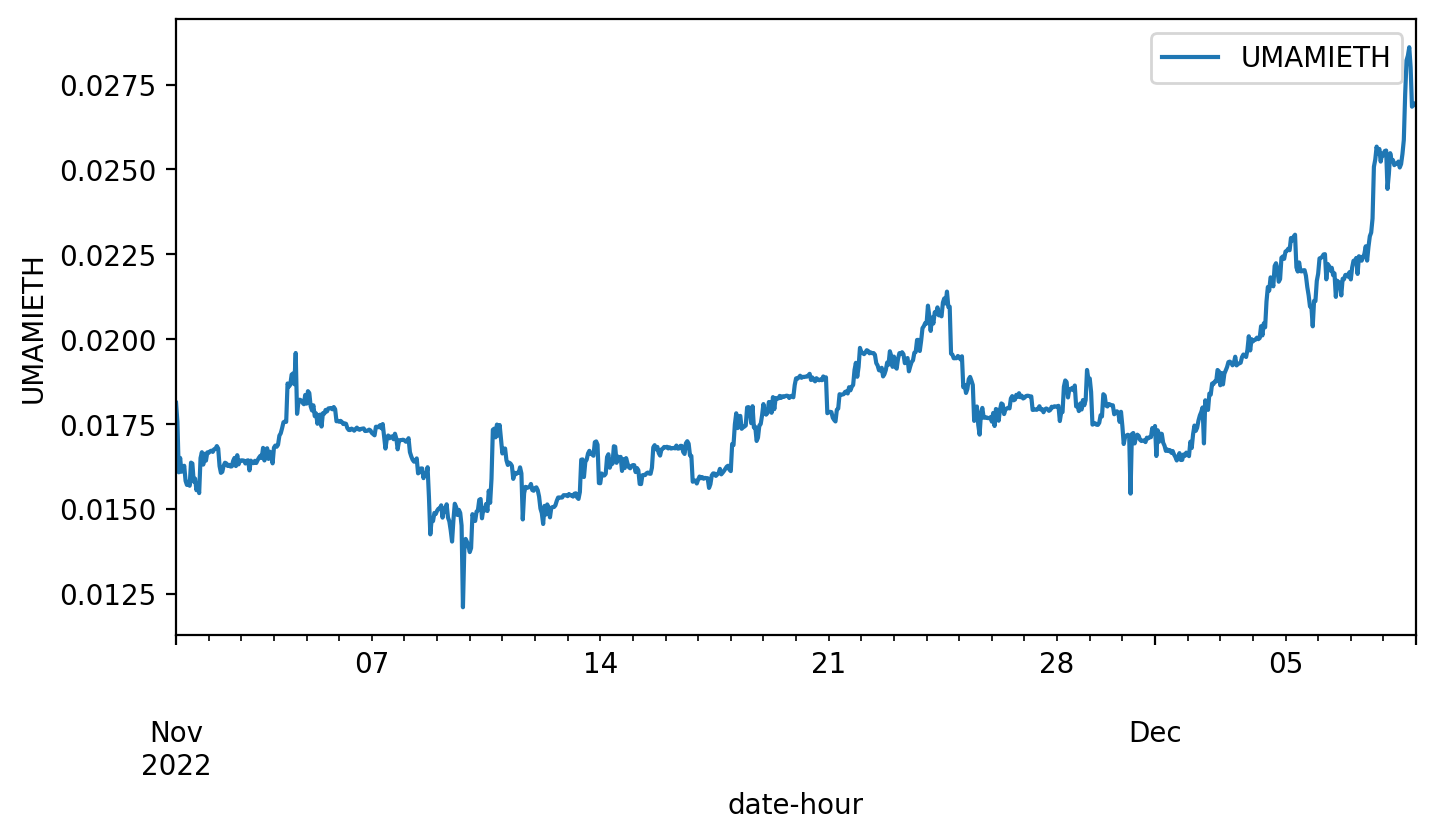

In [5]:
# plot UMAMIETH
df.plot(y='UMAMIETH', fontsize=10)
plt.xlabel('date-hour', fontsize=10)
plt.ylabel('UMAMIETH', fontsize=10)
plt.show()

### Explore Data

In [6]:
# check missing
df.isna().sum()

UMAMI       0
WETH        0
UMAMIETH    0
dtype: int64

In [7]:
# summary stats
df.describe()

,UMAMI,WETH,UMAMIETH
count,913.00,913.00,913.00
mean,23.42,"1,299.58",0.02
std,3.60,150.75,0.00
min,14.05,"1,085.42",0.01
25%,20.93,"1,208.86",0.02
50%,22.11,"1,255.18",0.02
75%,25.90,"1,292.85",0.02
max,36.82,"1,664.63",0.03


### Forecast next-hour UMAMIETH price using prior hourly prices with ARMA model

Summary of steps:

1. Split the `UMAMIETH` series into training and test sets.
2. Scale the data so that all values are in the range of 0 and 1.
3.1. Pick how many lags to use for the AutoRegression (AR) component.
3.2. Pick how many lags to use for the Moving Average (MA) component.
1. Train an ARMA model on training set, and review parameter estimates.
2. Train and forecast iteratively and calculate prediction error.

In [8]:
umamieth = df.UMAMIETH.asfreq('H') # need to set a frequence otherwise some function downstream will warn

In [9]:
# 1. split into train and test sets
train_stop_time = '2022-12-03 23:00:00'
train = umamieth[umamieth.index <= train_stop_time].to_frame()
test  = umamieth[umamieth.index > train_stop_time].to_frame()
print('Training data size:', len(train))
print(train.tail(), end='\n\n')
print('Test data size:', len(test))
print(test.head())

Training data size: 792
                     UMAMIETH
datetime                     
2022-12-03 19:00:00      0.02
2022-12-03 20:00:00      0.02
2022-12-03 21:00:00      0.02
2022-12-03 22:00:00      0.02
2022-12-03 23:00:00      0.02

Test data size: 121
                     UMAMIETH
datetime                     
2022-12-04 00:00:00      0.02
2022-12-04 01:00:00      0.02
2022-12-04 02:00:00      0.02
2022-12-04 03:00:00      0.02
2022-12-04 04:00:00      0.02


In [10]:
# 2. scale data to (0, 1). Notice that we train a scaler() on training data first 
# and apply it to the test set to avoid data leaking.
scaler = MinMaxScaler()
train['UMAMIETH'] = scaler.fit_transform(train)

# scale test data to be in range(0, 1)
test['UMAMIETH'] = scaler.transform(test)

# print scaled data
print('Scaled training set:')
print(train.tail(), end='\n\n')
print('Scaled test set:')
print(test.head())

Scaled training set:
                     UMAMIETH
datetime                     
2022-12-03 19:00:00      0.79
2022-12-03 20:00:00      0.82
2022-12-03 21:00:00      0.86
2022-12-03 22:00:00      0.81
2022-12-03 23:00:00      0.85

Scaled test set:
                     UMAMIETH
datetime                     
2022-12-04 00:00:00      0.84
2022-12-04 01:00:00      0.85
2022-12-04 02:00:00      0.85
2022-12-04 03:00:00      0.85
2022-12-04 04:00:00      0.85


In [11]:
# 3.1 how many lags shall we use for the AR component?
#    lag1: price at last hour, t-1
#    lag2: price 2 hours ago at t-2
#    lag3: price 3 hours ago at t-3
#
# Use ar_select_order() to pick the optimal number of AR lags automatically
sel = ar_select_order(train, maxlag=40)
print('Best lags to use in autoregression:', sel.ar_lags, end='\n\n')
model_fit = sel.model.fit()
print('Autoregression trained with best lags:')
print(model_fit.summary())

Best lags to use in autoregression: [1, 2]

Autoregression trained with best lags:
                            AutoReg Model Results                             
Dep. Variable:               UMAMIETH   No. Observations:                  792
Model:                     AutoReg(2)   Log Likelihood                1581.727
Method:               Conditional MLE   S.D. of innovations              0.033
Date:                Sat, 10 Dec 2022   AIC                          -3155.454
Time:                        11:57:24   BIC                          -3136.766
Sample:                    11-01-2022   HQIC                         -3148.271
                         - 12-03-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0096      0.004      2.145      0.032       0.001       0.018
UMAMIETH.L1     0.7620      0.035     21.985 

The algo says the optimal number of AR lags is 2.

In [12]:
# 3.2 how many lags shall we use for the MA component? 
#    lag1: forecast error at last hour, t-1
#    lag2: forecast error at t-2
#
# Let's experiment by trying 1, 2 lags. That is, we'll fit a ARMA(1,1) and 
# ARMA(1,2) and check the residuals. We're using the ARIMA() function, which 
# takes an `order` argument where the middle value is the order of difference 
# for integration, something we don't care about right now so we set it to zero. 
arma21 = ARIMA(train, order=(2,0,1)).fit() # ARIMA(2, 0, 1), same as ARMA(2, 1)
arma22 = ARIMA(train, order=(2,0,2)).fit() # ARIMA(2, 0, 2), same as ARMA(2, 2)

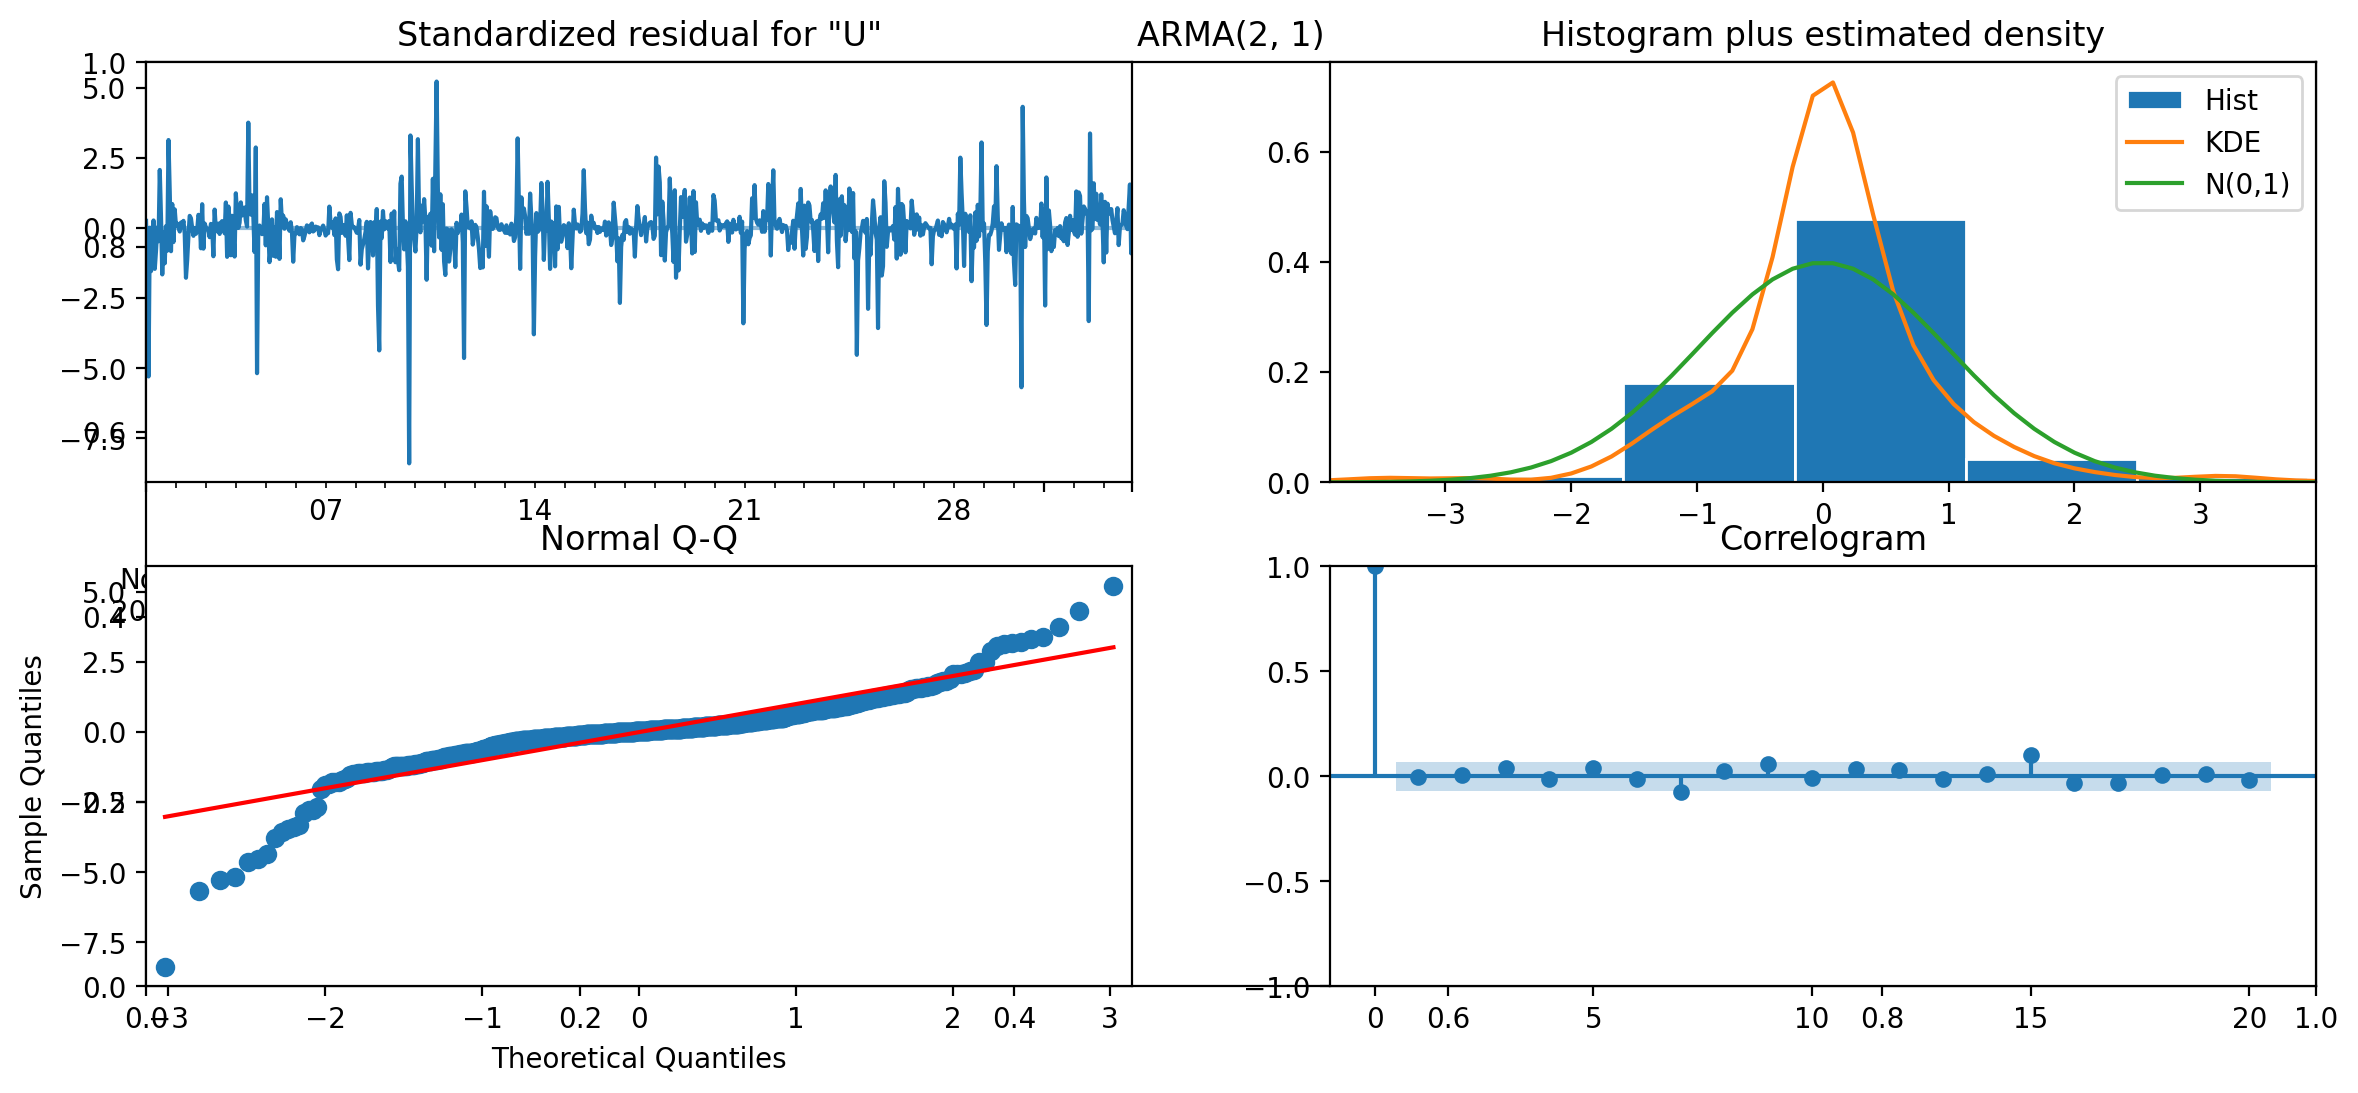

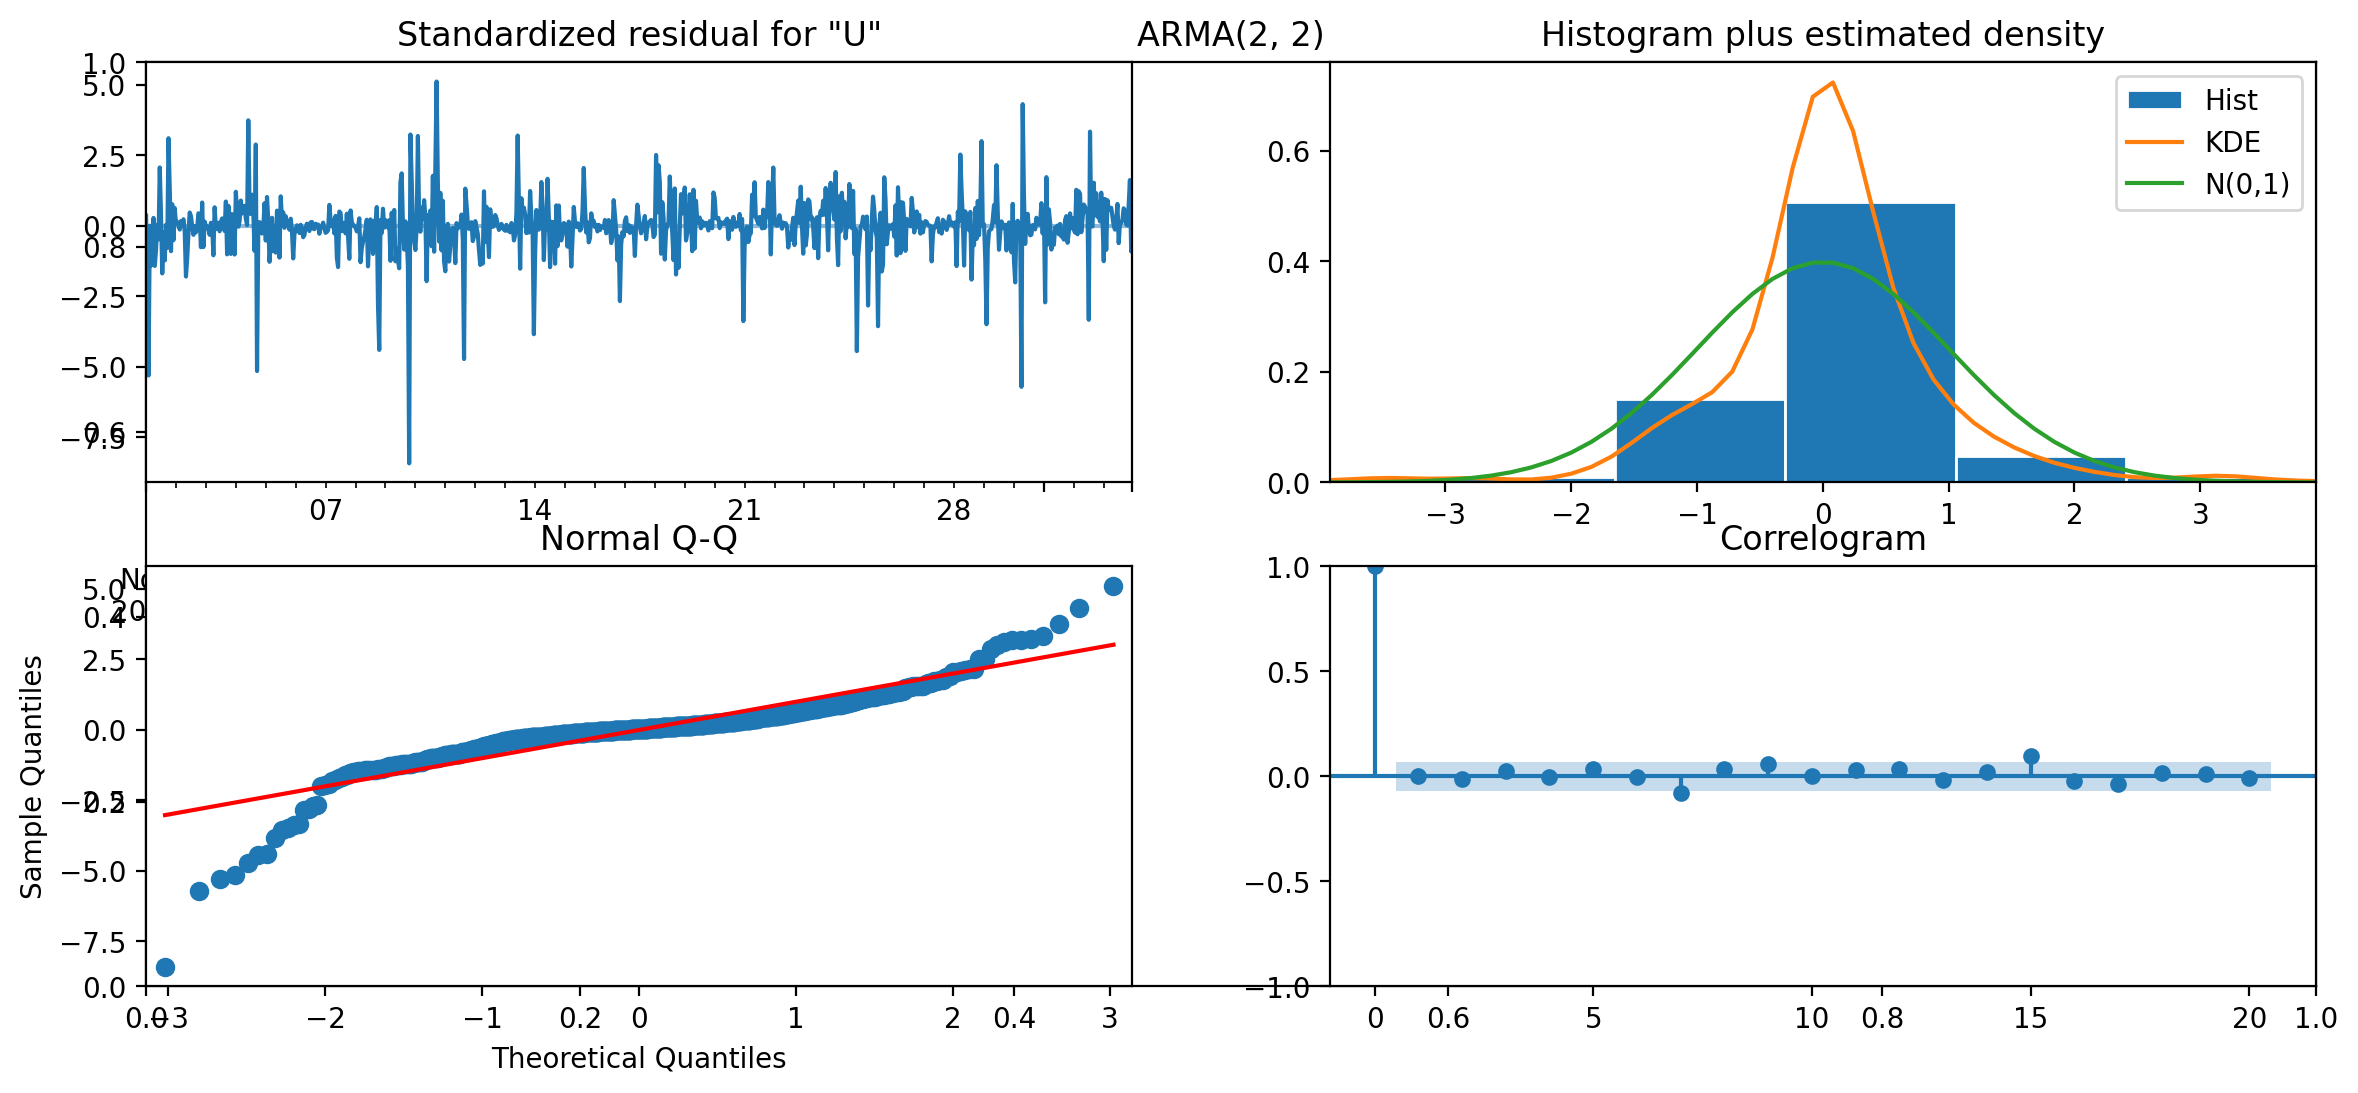

In [13]:
# let's examine residual diagnostics
fig1 = plt.figure(figsize=(14, 6))
plt.title('ARMA(2, 1)')
fig1 = arma21.plot_diagnostics(fig=fig1, lags=20)

fig2 = plt.figure(figsize=(14, 6))
plt.title('ARMA(2, 2)')
fig2 = arma22.plot_diagnostics(fig=fig2, lags=20)

The above correlograms of the residuals show almost all lollipop sticks squashed 
down inside the blue 95% confidence band except at lag 15. This says both 
ARMA(2, 1) and ARMA(2, 2) are able to explain away the autocorrelation in the 
series. The tiny peak at lag 15 don't bother us much because it's expected that 
5% out of the 20 lags will be non-zero due to sampling variation.

Remark: In general, to identify the best order for a MA model, we want to fit a 
`ARMA(0,q)` and look at the correlogram of the residuals and see how many 
non-zero lags exist consecutively. Lollipop sticks squashed down inside the 
blue 95% confidence band are effectively zeros, whereas the ones that extend 
beyond the blue band are non-zeros. If `n` consecutive non-zero lags exist, the
best value for `q` would be `n`.

In [14]:
# let's examine the cofficients of the fitted ARMA(2, 1) model
arma21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               UMAMIETH   No. Observations:                  792
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1585.643
Date:                Sat, 10 Dec 2022   AIC                          -3161.286
Time:                        11:57:48   BIC                          -3137.913
Sample:                    11-01-2022   HQIC                         -3152.303
                         - 12-03-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6027      0.108      5.596      0.000       0.392       0.814
ar.L1          1.1102      0.140      7.945      0.000       0.836       1.384
ar.L2         -0.1180      0.137     -0.859      0.391      -0.387       0.151
ma.L1         -0.3654      0.138     -2.646      0.008      -0.636      -0.095
sigma2         0.0011   2.11e-05     50.413      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5503.28
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -1.33
Prob(H) (two-sided):                  0.01   Kurtosis:                        15.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see the coefficient estimate of lag2 (`ar.L2`) is insignificant, suggesting 
us to drop it and refit a `ARMA(1, 1)` model. This contradicts to what the 
auto-selection algo told us that the best AR order is 2.

In [15]:
# let's examine the cofficients of the fitted ARMA(2, 2) model
arma22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               UMAMIETH   No. Observations:                  792
Model:                 ARIMA(2, 0, 2)   Log Likelihood                1586.225
Date:                Sat, 10 Dec 2022   AIC                          -3160.449
Time:                        11:58:01   BIC                          -3132.402
Sample:                    11-01-2022   HQIC                         -3149.670
                         - 12-03-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5912      0.079      7.531      0.000       0.437       0.745
ar.L1          0.0117      0.051      0.227      0.820      -0.089       0.113
ar.L2          0.9639      0.052     18.656      0.000       0.863       1.065
ma.L1          0.7279      0.057     12.858      0.000       0.617       0.839
ma.L2         -0.2512      0.025     -9.959      0.000      -0.301      -0.202
sigma2         0.0011   2.17e-05     48.851      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              5587.69
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see `ar.L2` becomes significant in the presence of `ma.L2`, but `ar.L1` is 
now insignificant. Obiously we can't drop `ar.L1`. So we will 
go with the more parsimonious `ARMA(1,1)` model. 

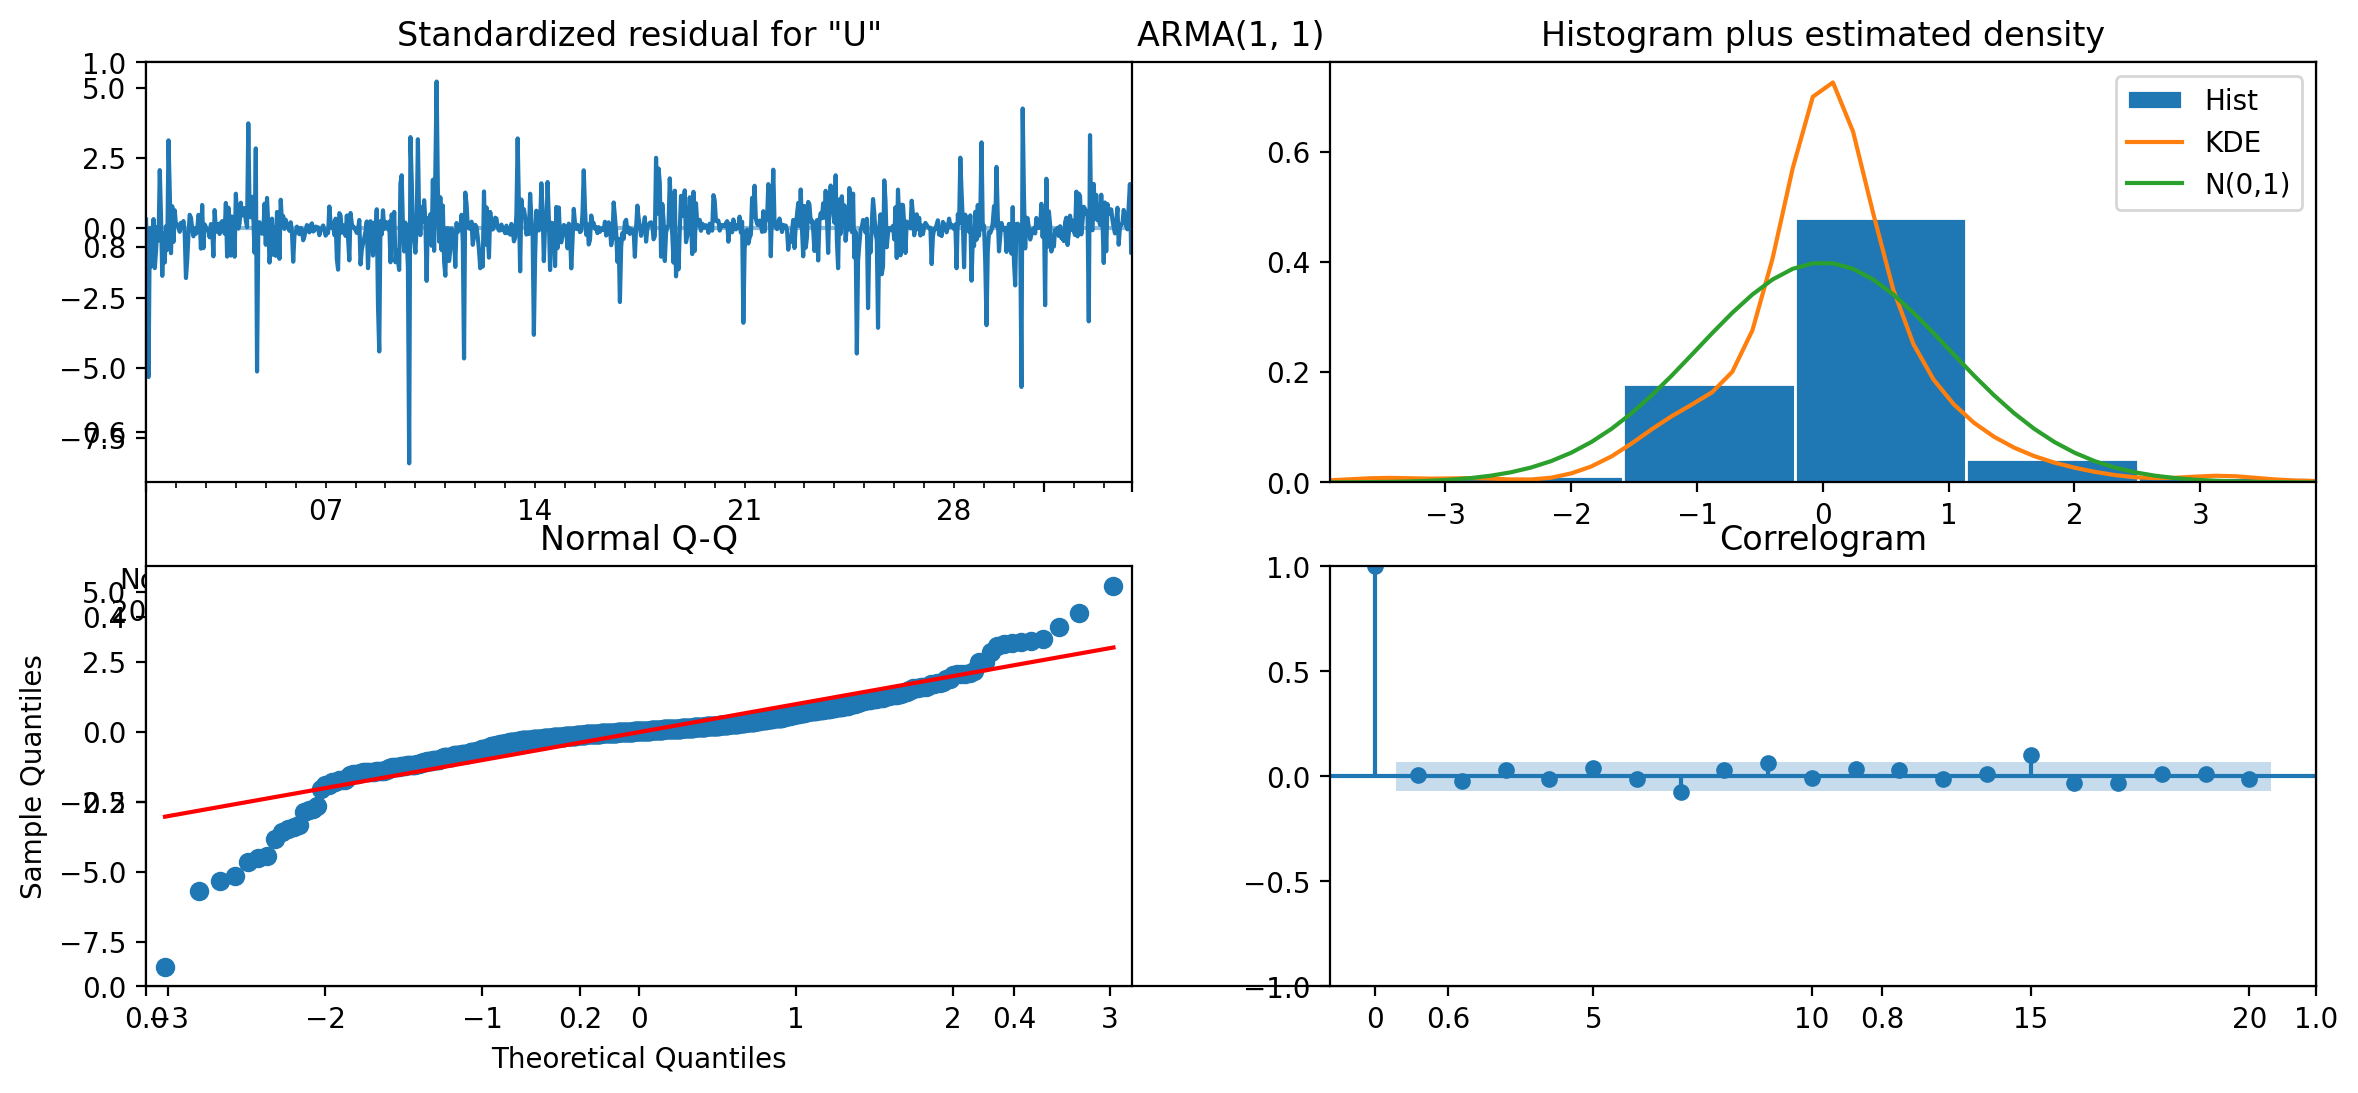

In [16]:
# fit a ARMA(1,1)
arma11 = ARIMA(train, order=(1,0,1)).fit() # ARIMA(1, 0, 1), same as ARMA(1, 1)

# check model diagnostics
fig3 = plt.figure(figsize=(14, 6))
plt.title('ARMA(1, 1)')
fig3 = arma11.plot_diagnostics(fig=fig3, lags=20)

#### Iterative training and forecasting

Now that we know the optimal order for the AR and MA components are 1 and 1. 
Let's train an ARMA(1, 1) and make forecasts iteratively on a rolling 1-step 
basis. That is, as we iterate over the timestamps in the test set, we will

1. train an ARMA(1, 1) on the training set,
2. make a 2-step forecast, i.e., predict for the next 1 hour and the next 2 hour,
3. grow the training set by including the test set observation at that timestamp.

In [17]:
# how many records do you want to use for initial training? 
# set len(train) to use full training data. But we probably want to use a subset
# of more recent data since momentum breaks over a long period. Here I'm using 
# the previous 10 days, and each day has 24 hours. 
training_size = 10 * 24 

# extract training and test timeseries
ts_train = train.UMAMIETH[-training_size:]
ts_test = test.UMAMIETH

# change to list because we'll need to pop() and append() to training series
ts_train = list(ts_train)

In [18]:
# how many steps ahead do you want to forecast?
horizon = 2

In [19]:
# iterative ARMA(1,1) fitting and forecasting
predictions = list()
for t in range(len(ts_test)):
    model = ARIMA(ts_train, order=(1,0,1)).fit()
    yhat = model.forecast(steps=horizon) # forecast() gives a numpy array
    obs = ts_test[t]
    predictions.append(yhat)
    # grow training timeseries by adding current test set observation to the end
    ts_train.append(obs)

/Users/gmlang/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gmlang/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gmlang/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gmlang/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimiz

In [20]:
# make actual test series into a frame according to forecast horizon
df_actuals = pd.DataFrame({
    'UMAMIETH_t{}'.format(t+1): test.UMAMIETH.shift(-t) for t in range(horizon)})
df_actuals.head()

,UMAMIETH_t1,UMAMIETH_t2
datetime,,
2022-12-04 00:00:00,0.84,0.85
2022-12-04 01:00:00,0.85,0.85
2022-12-04 02:00:00,0.85,0.85
2022-12-04 03:00:00,0.85,0.85
2022-12-04 04:00:00,0.85,0.85


In [21]:
# reverse the scaling operation to get back at the original scale
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(df_actuals)

In [22]:
# put acutals and predictions side by side in the same data frame
df_pred = pd.DataFrame(
    np.concatenate([actuals, predictions], axis=1), 
    columns=list(df_actuals.columns) + ['forecast_t{}'.format(t+1) for t in range(horizon)], 
    index=test.index)
df_pred.head()

,UMAMIETH_t1,UMAMIETH_t2,forecast_t1,forecast_t2
datetime,,,,
2022-12-04 00:00:00,0.02,0.02,0.02,0.02
2022-12-04 01:00:00,0.02,0.02,0.02,0.02
2022-12-04 02:00:00,0.02,0.02,0.02,0.02
2022-12-04 03:00:00,0.02,0.02,0.02,0.02
2022-12-04 04:00:00,0.02,0.02,0.02,0.02


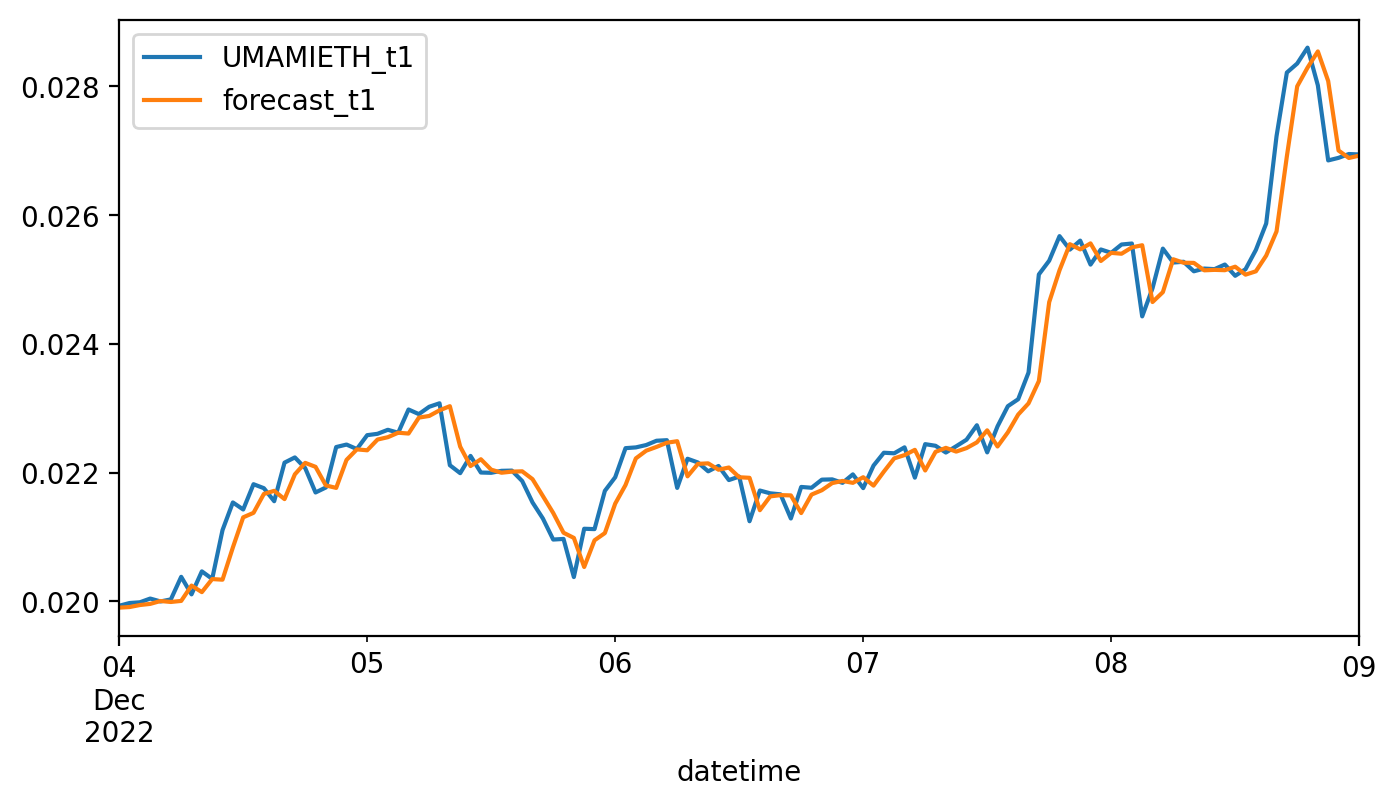

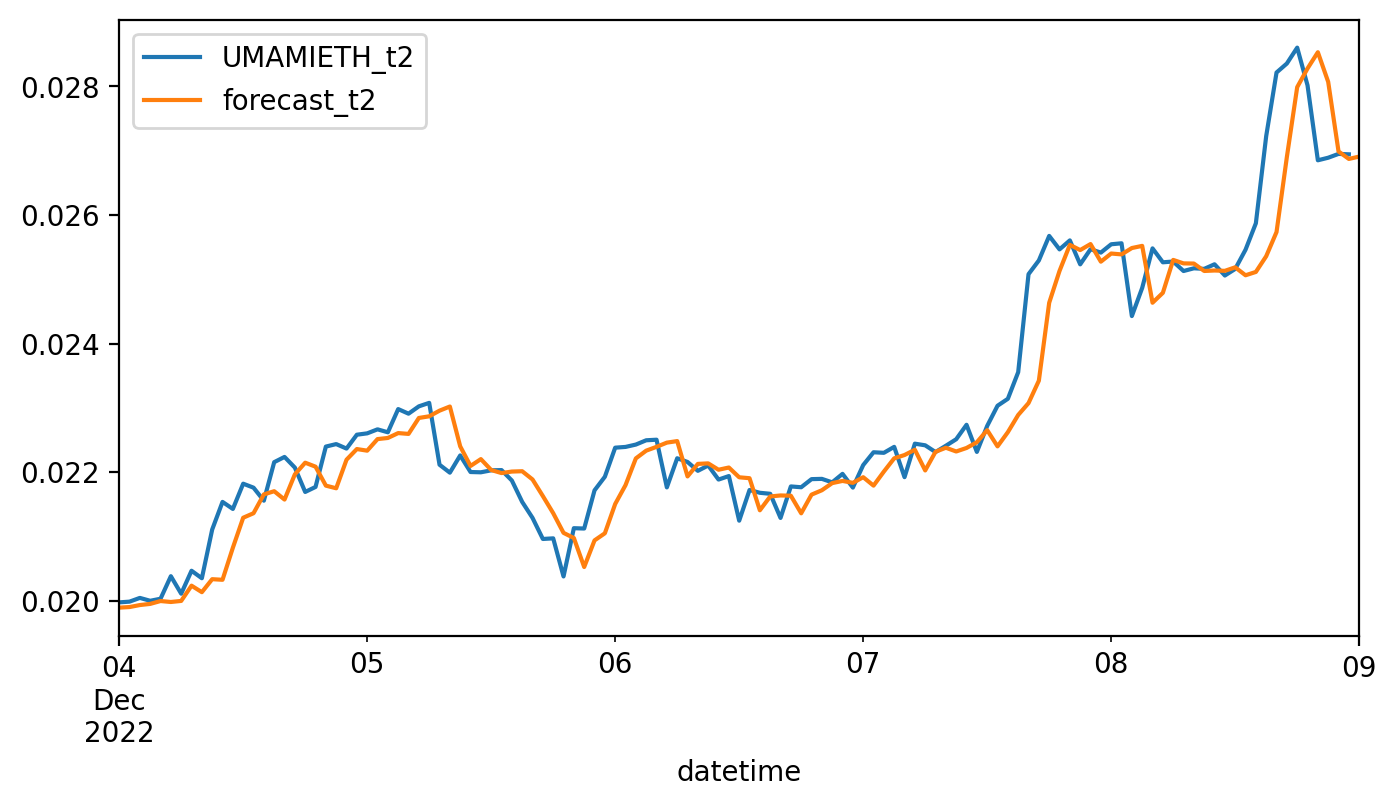

In [23]:
# plot forecast vs observations
df_pred[['UMAMIETH_t1', 'forecast_t1']].plot();
df_pred[['UMAMIETH_t2', 'forecast_t2']].plot();

In [24]:
def MAPE(actuals, predictions):
    """Calculate mean absolute percentage error"""
    return (abs(actuals - predictions) / actuals).mean()

one_step_mape = MAPE(df_pred.UMAMIETH_t1, df_pred.forecast_t1)

multi_step_mape = 0
for t in range(horizon):
    actuals = df_pred['UMAMIETH_t{}'.format(t+1)]
    forecasts = df_pred['forecast_t{}'.format(t+1)]
    multi_step_mape += MAPE(actuals, forecasts)
multi_step_mape /= horizon 

print("1-step forecast MAPE: ", format(one_step_mape, '.3%'))
print('{}-step forecast MAPE: '.format(horizon), format(multi_step_mape, '.3%'))

1-step forecast MAPE:  1.200%
2-step forecast MAPE:  1.471%
